In [1]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
df = pd.read_csv('CAM-01-SRV-lvm1.csv', header=None)
df.columns = ['Timestamp', 'Hostname', 'DiskNumber', 'Type', 'Offset', 'Size', 'ResponseTime']
df['Timestamp'] = df['Timestamp'].astype(np.int64)
df = df.sort_values(by='Timestamp')
total_request_num = df.shape[0]
print(total_request_num)

45283980


In [3]:
def make_requests():
    for row in df.itertuples():
        yield getattr(row, 'Offset'), getattr(row, 'Size')

In [4]:
class Server:  # 服务器(cache)
    def __init__(self, space):
        self.space = space  # cache大小
        self.remain = space  # cache剩余空间
        self.cache = OrderedDict()  # OrderDict() 模拟cache LRU方法
        self.hit_count = 0  # 命中次数
        self.hit_byte = 0
        self.miss_count = 0  # 未命中次数
        self.miss_byte = 0

    def _hit(self, fid, size):
        self.hit_count += 1
        self.hit_byte += size
        self.cache.move_to_end(fid)

    def _miss(self, fid, size):
        self.miss_count += 1
        self.miss_byte += size
        while self.remain < size:
            self.remain += self.cache.popitem(last=False)[-1]  # pop出第一个item
        self.cache[fid] = size
        self.remain -= size

    def handle(self, fid, size):  # 处理一次请求
        if fid in self.cache.keys():
            self._hit(fid, size)
        else:
            self._miss(fid, size)

    def hit_rate(self):
        try:
            return self.hit_count / (self.hit_count + self.miss_count)
        except:
            return 0

    def byte_hit_rate(self):
        try:
            return self.hit_byte / (self.hit_byte + self.miss_byte)
        except:
            return 0

In [5]:
class Dispatcher:
    def __init__(self, cache_size, cache_number, index, window_size, simple=True):
        self.cache_number = cache_number
        self.index = index                # 权重
        self.window_size = window_size              # 窗口大小
        self.window = 0                             # 当前窗口大小
        self.big_cache = Server(cache_size * cache_number)
        self.small_caches = []
        for i in range(cache_number):
            server = Server(cache_size)
            self.small_caches.append(server)
        self.small_caches_heat = [0] * cache_number     # 累积热度
        self.small_caches_heat_temp = [0] * cache_number   # 时间窗口内的热度
        if simple:
            self.handle_requests = self.simple_hash
        else:
            self.handle_requests = self.load_balance
            self.file_mapper = {}
            for row in df.drop_duplicates(['Offset']).itertuples():
                fid = getattr(row, 'Offset')
                self.file_mapper[fid] = (fid // 10000 % 1000000) & 0b11111 % cache_number


    def load_balance(self, fid, size):
        self.window += 1         # 窗口增大1
        if self.window % self.window_size == 0:     # 更新热度
            for i in range(self.cache_number):
                self.small_caches_heat[i] = self.index * self.small_caches_heat[i] + (1 - self.index) * self.small_caches_heat_temp[i]
                self.small_caches_heat_temp[i] = 0            # 当前窗口热度置零
        
        server = self.file_mapper[fid]
        if fid in self.small_caches[server].cache.keys():
            self.small_caches[server].handle(fid, size)
            self.small_caches_heat_temp[server] += size
        else:
            server = self.small_caches_heat.index(min(self.small_caches_heat))
            self.small_caches[server].handle(fid, size)
            self.file_mapper[fid] = server

        self.big_cache.handle(fid, size)

    def simple_hash(self, fid,  size):
        self.small_caches[(fid // 10000 % 1000000) & 0b11111 % self.cache_number].handle(fid, size)

In [6]:
CACHE_SIZE = 16384000000
CACHE_NUM = 4
INDEX = 0.9
window_index = [0.0001, 0.001, 0.01, 0.1]
window_size_array = [int(total_request_num * i) for i in window_index]
print(window_size_array)

# 记录不同window_size下的大小cache的命中率
small_cache_hit_ratio = []  
big_cache_hit_ratio = []

[4528, 45283, 452839, 4528398]


In [7]:
for window_size in window_size_array:   # 不同窗口大小的命中率
    dispatcher = Dispatcher(CACHE_SIZE, CACHE_NUM, INDEX, window_size, False)
    for fid, size in tqdm(make_requests()): 
        dispatcher.handle_requests(fid, size)
        
    small_cache_hit_ratio.append(sum([i.hit_byte for i in dispatcher.small_caches]) / (dispatcher.big_cache.hit_byte + dispatcher.big_cache.miss_byte))
    big_cache_hit_ratio.append(dispatcher.big_cache.hit_byte / (dispatcher.big_cache.hit_byte + dispatcher.big_cache.miss_byte))

45283980it [03:40, 205436.74it/s]
45283980it [03:45, 201179.73it/s]
45283980it [03:42, 203320.26it/s]
45283980it [03:40, 205698.07it/s]


d:\program files\python 3.7.4\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 19981 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\program files\python 3.7.4\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 21516 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\program files\python 3.7.4\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 31383 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\program files\python 3.7.4\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 21475 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\program files\python 3.7.4\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 22823 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\program files\python 3.7.4\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarni

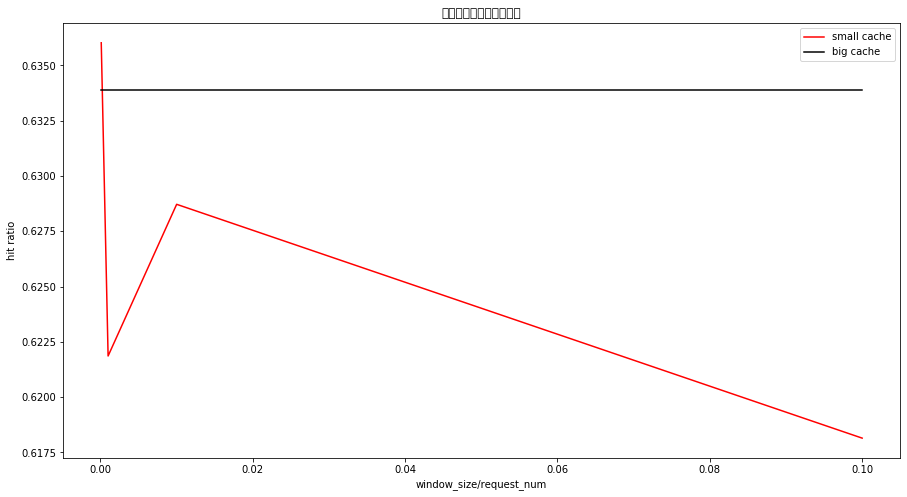

In [8]:
#查看不同窗口大小下的命中率
plt.figure(figsize=(15, 8))
plt.plot(window_index, small_cache_hit_ratio, color='red', label='small cache')
plt.plot(window_index, big_cache_hit_ratio, color='black', label='big cache')
plt.xlabel("window_size/request_num")
plt.ylabel("hit ratio")
plt.title("不同窗口大小下的命中率")
plt.legend()
plt.show()

In [9]:
colors = ['gold', 'green', 'pink', 'brown']
time_array = []
window_size = int(0.001 * total_request_num)
#记录实时命中率
small_cache_hit_ratio_realtime = [] # 各个小cache的实时命中率
small_cache_hit_ratio_realtime_total = []  # 小cache总的实时命中率
big_cache_hit_ratio_realtime = []          # 大cache的实时命中率


In [10]:
dispatcher2 = Dispatcher(CACHE_SIZE, CACHE_NUM, INDEX, window_size, False)
time = 0
for fid, size in tqdm(make_requests()):
    time +=1
    dispatcher2.handle_requests(fid, size)
    if time % 100 == 0:
        time_array.append(time)
        small_cache_hit_ratio_realtime.append([j.byte_hit_rate() for j in dispatcher2.small_caches])
        small_cache_hit_ratio_realtime_total.append(sum([i.hit_byte for i in dispatcher2.small_caches]) / (dispatcher2.big_cache.hit_byte + dispatcher2.big_cache.miss_byte))
        big_cache_hit_ratio_realtime.append(dispatcher2.big_cache.hit_byte / (dispatcher2.big_cache.hit_byte + dispatcher2.big_cache.miss_byte))

45283980it [03:53, 193847.17it/s]


d:\program files\python 3.7.4\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 23454 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\program files\python 3.7.4\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 26102 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\program files\python 3.7.4\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 23454 missing from current font.
  font.set_text(s, 0, flags=flags)
d:\program files\python 3.7.4\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 26102 missing from current font.
  font.set_text(s, 0, flags=flags)
d:\program files\python 3.7.4\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


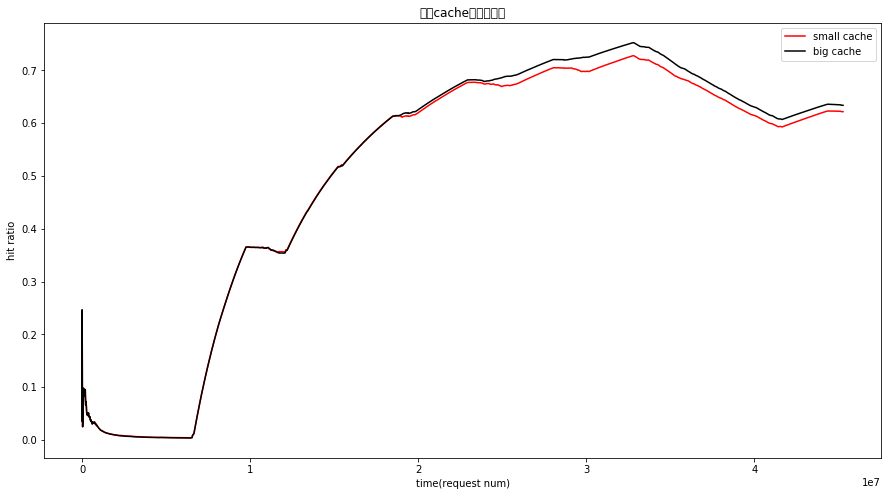

In [11]:
#查看实时命中率
plt.figure(figsize=(15, 8))
plt.plot(time_array, small_cache_hit_ratio_realtime_total, color='red', label='small cache')
plt.plot(time_array, big_cache_hit_ratio_realtime, color='black', label='big cache')
plt.xlabel("time(request num)")
plt.ylabel("hit ratio")
plt.title("大小cache实时命中率")
plt.legend()
plt.show()

d:\program files\python 3.7.4\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 21508 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\program files\python 3.7.4\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 20010 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\program files\python 3.7.4\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 21508 missing from current font.
  font.set_text(s, 0, flags=flags)
d:\program files\python 3.7.4\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 20010 missing from current font.
  font.set_text(s, 0, flags=flags)


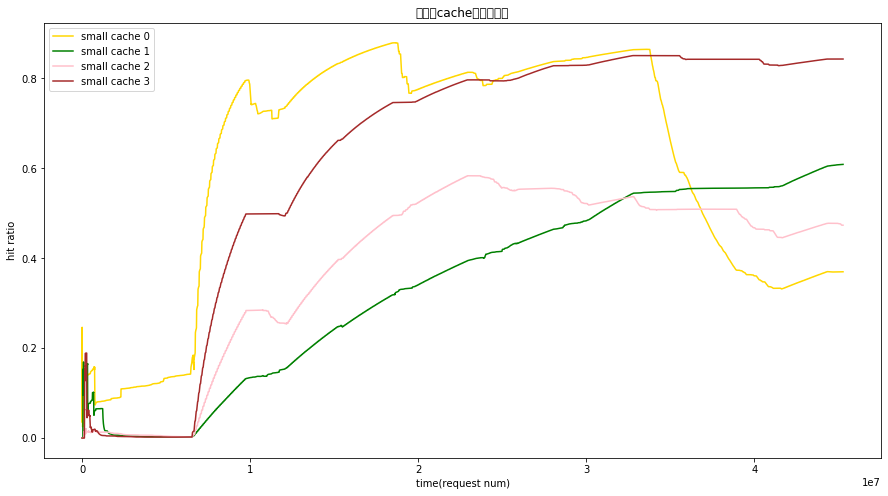

In [12]:
#查看各个小cache的实时命中率
plt.figure(figsize=(15, 8))
for i in range(CACHE_NUM):
    plt.plot(time_array, [j[i] for j in small_cache_hit_ratio_realtime], color=colors[i], label="small cache "+str(i))
plt.xlabel("time(request num)")
plt.ylabel("hit ratio")
plt.title("各个小cache实时命中率")
plt.legend()
plt.show()
